# IMPORTS ET KILL DE KERNEL

In [74]:
# kill the kernel to release gpu performances
pid = os.getpid()
!kill -9 $pid

In [1]:
# imports
import numpy as np
import os
import os.path
import pandas as pd
pd.options.display.max_colwidth = 100
import cv2
import tensorflow as tf
import pickle
import copy
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# VARIABLES

In [2]:
# definitions des variables
model_path = '/home/acarlier/code/OrnithoScope/saved_models/model_efficientDet1.tflite'
input_csv_path = '/home/acarlier/code/OrnithoScope/data/input.csv'
columns_names = ["split_value", "file_path", "label",
                      "x_min", "y_min", "empty_1", "empty_2",
                      "x_max", "y_max", "empty_3"]
output_images_directory = '/home/acarlier/code/data_ornitho/output_images/test_pickle/'
comparaison_images_directory = '/home/acarlier/code/data_ornitho/comparaison_verite_terrain/comparaison_efficientDet1/'


# FUNCTIONS

In [3]:
#@title Load the trained TFLite model and define some visualization functions

def get_classes_from_input():
    input = pd.read_csv(input_csv_path, names = columns_names)
    return input["label"].unique().tolist()

# Load the labels into a list
classes = get_classes_from_input()
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  #print(tf.shape(resized_img))
  return resized_img, original_image

def preprocess_images(image_paths, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_paths[0])
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  
  resized_imgs = resized_img
  
  for i in range(1,len(image_paths)):
    img = tf.io.read_file(image_paths[i])
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    resized_img = tf.image.resize(img, input_size)
    resized_img = resized_img[tf.newaxis, :]
    resized_img = tf.cast(resized_img, dtype=tf.uint8)
    
    resized_imgs = tf.concat([resized_imgs, resized_img], axis=0)
    #print(tf.shape(resized_imgs))
    
  return resized_imgs


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()
  #print("avant modèle")
  # Feed the input image to the model
  output = signature_fn(images=image)
  #interpreter.set_tensor(0, image)
  #interpreter.invoke()
  #print("après modèle")
  
  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']
  print(input_height, input_width)
  #print("interpreter")
  
  # Load the input image and preprocess it
  preprocessed_image, _ = preprocess_image(
      image_path,
      (input_height, input_width)
    )
  #print("preprocessing")
  
  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
  #print("detection")
  
  if 0:
    # Plot the detection results on the input image
    original_image_np = original_image.numpy().astype(np.uint8)
    for obj in results:
      # Convert the object bounding box from relative coordinates to absolute
      # coordinates based on the original image resolution
      ymin, xmin, ymax, xmax = obj['bounding_box']
      xmin = int(xmin * original_image_np.shape[1])
      xmax = int(xmax * original_image_np.shape[1])
      ymin = int(ymin * original_image_np.shape[0])
      ymax = int(ymax * original_image_np.shape[0])

      # Find the class index of the current object
      class_id = int(obj['class_id'])

      # Draw the bounding box and label on the image
      color = [int(c) for c in COLORS[class_id]]
      cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
      # Make adjustments to make the label visible for all objects
      y = ymin - 15 if ymin - 15 > 15 else ymin + 15
      label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
      cv2.putText(original_image_np, label, (xmin, y),
          cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Return the final image
    original_uint8 = original_image_np.astype(np.uint8)
  original_uint8 = None  
  return original_uint8, results

# Génération des prédictions

In [4]:
# get unique test images as a df
def get_test_images():
    input = pd.read_csv(input_csv_path, names = columns_names)
    test_dataset = input.loc[input['split_value'] == 'TEST']
    list_image_test = test_dataset["file_path"].unique().tolist() # return all unique file_path to test, no prediction on two same image
    return list_image_test
loi = get_test_images()
print(loi[0])
print(len(loi))

/home/acarlier/OrnithoMate/p0133_bird_data/raw_data/task_2021-03-01_09/20210301-090002_(13.0).jpg
3516


In [5]:
# get predictions from model
def prediction_test_dataset():
    results = []
    list_of_images = get_test_images()
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    #list_of_images = ['/home/acarlier/code/test/2021-06-11-13-44-43.jpg']
    # Load the TFLite model
    print(len(list_of_images),' to predict')
    for img in list_of_images:
        if list_of_images.index(img)%100 == 0:
            print(list_of_images.index(img))
        img_name = img.split('/')[-1]
        file_path = '{}{}'.format(output_images_directory, img_name)
        if os.path.exists(file_path):
            list_of_images.remove(img)
            #print(len(list_of_images),' remaining')
        else:
            INPUT_IMAGE_URL = img #@param {type:"string"}
            DETECTION_THRESHOLD = 0.3 #@param {type:"number"}
            TEMP_FILE = img
            FILE_NAME = TEMP_FILE.split("/")[-1]
            #print('test1.2 : ok')
            #!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
            #!wget -q -O $INPUT_IMAGE_URL
            #print('test1.3 : ok')
            try:
                with open(TEMP_FILE) as file:
                    #im = Image.open(TEMP_FILE)
                    #im.thumbnail((512, 512), Image.ANTIALIAS)
                    #im.save(TEMP_FILE, 'JPEG')
                    # Run inference and draw detection result on the local copy of the original file
                    detection_result_image, result = run_odt_and_draw_results(
                        TEMP_FILE,
                        interpreter,
                        threshold=DETECTION_THRESHOLD
                    )
                    results.append(result)
                    # Show the detection result
                    #Image.fromarray(detection_result_image)
                    #result = Image.fromarray(detection_result_image)
                    #result.save("{}{}".format(output_images_directory, FILE_NAME), 'JPEG')
                    #result.show()
            except OSError as e:
                print(e.errno)
    return results

In [6]:
# get predictions with batchs
def batched_prediction_test_dataset(batch_size):
    results = []
    list_of_images = get_test_images()
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    #list_of_images = ['/home/acarlier/code/test/2021-06-11-13-44-43.jpg']
    # Load the TFLite model
    print(len(list_of_images),' to predict')
    for i in range(0, len(list_of_images), batch_size):
        
        images = list_of_images[i*batch_size:(i+1)*batch_size]

        DETECTION_THRESHOLD = 0.3 #@param {type:"number"}
        detection_result_image, result = run_odt_and_draw_results(
            images,
            interpreter,
            threshold=DETECTION_THRESHOLD
        )
        results.append(result)

            
    return results

In [7]:
# generate or load prediction results with pickles
#results_predictions = prediction_test_dataset()
#lts_predictions = prediction_test_dataset()
#pickle.dump(results_predictions, open( "/home/acarlier/code/OrnithoScope/saved_models/results_test.p", "wb" ) )
results_predictions = pickle.load( open( "/home/acarlier/code/OrnithoScope/saved_models/results_EfficientDet1.p", "rb" ) )
classes = get_classes_from_input()
print(len(results_predictions))
print(classes)
results_predictions[0]

3516
['MESCHA', 'SITTOR', 'MESBLE', 'MESNON', 'PINARB', 'ACCMOU', 'ROUGOR', 'VEREUR', 'MOIDOM', 'TOUTUR', 'ECUROU', 'PIEBAV', 'MULGRI', 'CAMPAG', 'MESNOI', 'MESHUP']


[{'bounding_box': array([0.08540744, 0.25474447, 0.68958795, 0.4716437 ], dtype=float32),
  'class_id': 7.0,
  'score': 0.6484375}]

# Préparation pour le calcul des precision recall

## Avoir la liste des labels prédits

### Conversion de l'id en nom

In [8]:
# fonction de convertions de l'id en nom
def convert_id_to_label_name(list_of_results,list_of_classes):
    results = copy.deepcopy(list_of_results)
    for i in range(len(results)):
        for result in results[i]:
            id = int(result['class_id'])
            result['class_id'] = list_of_classes[id]
    return results

In [9]:
results_converted = convert_id_to_label_name(results_predictions, classes)

In [10]:
print(classes)
print("Before ",results_predictions[:2])
print("After ",results_converted[:4])

['MESCHA', 'SITTOR', 'MESBLE', 'MESNON', 'PINARB', 'ACCMOU', 'ROUGOR', 'VEREUR', 'MOIDOM', 'TOUTUR', 'ECUROU', 'PIEBAV', 'MULGRI', 'CAMPAG', 'MESNOI', 'MESHUP']
Before  [[{'bounding_box': array([0.08540744, 0.25474447, 0.68958795, 0.4716437 ], dtype=float32), 'class_id': 7.0, 'score': 0.6484375}], [{'bounding_box': array([0.4092438, 0.5277908, 1.0296512, 0.7281122], dtype=float32), 'class_id': 0.0, 'score': 0.375}]]
After  [[{'bounding_box': array([0.08540744, 0.25474447, 0.68958795, 0.4716437 ], dtype=float32), 'class_id': 'VEREUR', 'score': 0.6484375}], [{'bounding_box': array([0.4092438, 0.5277908, 1.0296512, 0.7281122], dtype=float32), 'class_id': 'MESCHA', 'score': 0.375}], [{'bounding_box': array([0.5509056, 0.5129066, 0.9888495, 0.9870934], dtype=float32), 'class_id': 'MESCHA', 'score': 0.9296875}], [{'bounding_box': array([0.39843464, 0.30333823, 0.6451436 , 0.5669474 ], dtype=float32), 'class_id': 'VEREUR', 'score': 0.84765625}]]


In [11]:
# fonction de récupération de la liste des labels depuis les prédictions
def get_list_of_label_from_prediction(list_of_results):
    results = copy.deepcopy(list_of_results)
    l_final = []
    for i in range(len(results)):
        l = []
        for result in results[i]:
            label = result['class_id']
            l.append(label)
        l_final.append(l)
    return l_final

In [12]:
list_of_label_from_prediction = get_list_of_label_from_prediction(results_converted)
print(list_of_label_from_prediction[0])

['VEREUR']


## Avoir la liste de labels issus de la vérité terrain

In [13]:
# fonction qui génère le df clean et filtré de la vérité terrain
def generate_input_df(path_csv_input, columns_names): 
    df_input = pd.read_csv(path_csv_input, names = columns_names)
    df_input_test = df_input[df_input["split_value"] == 'TEST']
    print("From ",df_input_test.shape[0])
    print("to ",len(df_input_test['file_path'].unique()))
    return df_input_test

In [14]:
# fonction regroupant les observations vérité terrain par image
def df_groupby_filepath(df_input_test):
    df_test = copy.deepcopy(df_input_test)
    df_test = df_test[['file_path','label']]
    #df_test = df_test.groupby('file_path')
    #df_test.groupby('file_path')['label'].apply(lambda x: "[%s]" % ', '.join(x))
    df = df_test.groupby(['file_path'], sort=False)['label'].apply(lambda x: list(x)).to_frame().reset_index()
    #"%s" % ', '.join(x)
    return df

In [15]:
df_input_test = generate_input_df(input_csv_path, columns_names)
df_groupedby = df_groupby_filepath(df_input_test)
df_groupedby.head(2)

From  3771
to  3516


,file_path,label
0,/home/acarlier/OrnithoMate/p0133_bird_data/raw_data/task_2021-03-01_09/20210301-090002_(13.0).jpg,[VEREUR]
1,/home/acarlier/OrnithoMate/p0133_bird_data/raw_data/task_2021-03-01_09/20210301-090008_(9.0).jpg,[MESCHA]


# Calcul des precisions recall par classes

In [16]:
def get_metrics_by_comparing_two_lists(list1,list2):
    # cas où les listes sont égales
    metrics = {'TP':0, 'FP':0, 'FN':0}
    if list1 == list2:
        metrics['TP'] += len(list1)
    else:
        for element in list1:
            if element in list2:
                metrics['TP'] += 1
            elif element not in list2:
                metrics['FP'] += 1
        for element in list2:
            if element not in list1:
                metrics['FN'] += 1
    return metrics

In [17]:
# fonctions qui compare deux listes d'observations (prédites et vérité terrain) et qui ressort trois metriques TP,FP,FN
def evaluate_multiple_detections(true_labels, pred_labels):
  TP = []
  FP = copy.deepcopy(pred_labels)
  FN = copy.deepcopy(true_labels)
  for pl in pred_labels:
    if pl in true_labels:
        FP.remove(pl)
        FN.remove(pl)
        TP.append(pl)
  return TP, FN, FP

In [18]:
# fonctions qui compare deux listes d'observations (prédites et vérité terrain) AVEC TRY et qui ressort trois metriques TP,FP,FN
def evaluate_multiple_detections_try_version(true_labels, pred_labels):
  TP = []
  FP = copy.deepcopy(pred_labels)
  FN = copy.deepcopy(true_labels)
  for pl in pred_labels:
    if pl in true_labels:
      try:
        FP.remove(pl)
      except ValueError:
        "not in the list"
      try:
        FN.remove(pl)
      except ValueError:
        "not in the list"
      try:
        TP.append(pl)
      except ValueError:
        "not in the list"
  return TP, FN, FP

In [19]:
# tests sur les fonctions de prédictions
# première liste = prédiction et seconde liste = vérité terrain
test0 = evaluate_multiple_detections(['V'],['V']) #TP = 1
test1 = evaluate_multiple_detections(['V'],['M']) #FP = 1, FN = 1
test2 = evaluate_multiple_detections(['M'],['V']) #FN = 1, FP = 1

test0_2 = evaluate_multiple_detections(['M','V'],['M','V']) #TP = 2
test1_2 = evaluate_multiple_detections(['V', 'M'],['M','V']) #TP = 2
test2_2 = evaluate_multiple_detections(['TOUTUR', 'TOUTUR', 'MULGRI'],['TOUTUR']) #TP = 1, FP = 

print(f"\n 1 element : \n {test0} \n {test1} \n {test2} \n 2 elements : \n {test0_2} \n {test1_2} \n {test2_2}")


 1 element : 
 (['V'], [], []) 
 ([], ['V'], ['M']) 
 ([], ['M'], ['V']) 
 2 elements : 
 (['M', 'V'], [], []) 
 (['M', 'V'], [], []) 
 (['TOUTUR'], ['TOUTUR', 'MULGRI'], [])


In [25]:
# fonction de calcul des précisions recall et score f1 de chaque classe
def get_precision_recall_from_prediction(list_of_results, df_input_test, list_of_classes):
    class_metrics = []
    for classes in list_of_classes:
        class_metrics.append({'TP':0, 'FP':0, 'FN':0})
    
    for i in range(len(list_of_results)):
        pred_labels = list_of_results[i]
        #print('pred', pred_labels)
        true_labels = df_input_test.iloc[i]['label']
        #print('true', true_labels)
        TP, FN, FP = evaluate_multiple_detections_try_version(true_labels, pred_labels)
        #print(TP, FN, FP)
        
        for lab in TP:
            class_metrics[list_of_classes.index(lab)]['TP'] += 1
        
        for lab in FN:
            class_metrics[list_of_classes.index(lab)]['FN'] += 1
            
        for lab in FP:
            class_metrics[list_of_classes.index(lab)]['FP'] += 1
            
    return class_metrics

In [26]:
class_metrics = get_precision_recall_from_prediction(list_of_label_from_prediction, df_groupedby, classes)
class_metrics[0]

{'TP': 2434, 'FP': 283, 'FN': 80}

In [27]:
# fonction qui print les TP FP FN
def print_results_tpfpfn(class_metrics, list_of_species):
    for i in range(0, len(class_metrics)):
        TP = class_metrics[i]['TP']
        FP = class_metrics[i]['FP']
        FN = class_metrics[i]['FN']
        print(f"{list_of_species[i]} - TP : {TP} FP : {FP} FN : {FN}")

In [28]:
print_results_tpfpfn(class_metrics, get_classes_from_input())

MESCHA - TP : 2434 FP : 283 FN : 80
SITTOR - TP : 89 FP : 22 FN : 75
MESBLE - TP : 260 FP : 9 FN : 172
MESNON - TP : 157 FP : 61 FN : 45
PINARB - TP : 24 FP : 133 FN : 2
ACCMOU - TP : 72 FP : 59 FN : 20
ROUGOR - TP : 36 FP : 18 FN : 74
VEREUR - TP : 140 FP : 11 FN : 21
MOIDOM - TP : 2 FP : 31 FN : 21
TOUTUR - TP : 8 FP : 2 FN : 32
ECUROU - TP : 30 FP : 126 FN : 5
PIEBAV - TP : 158 FP : 9 FN : 16
MULGRI - TP : 1 FP : 4 FN : 18
CAMPAG - TP : 0 FP : 0 FN : 0
MESNOI - TP : 14 FP : 13 FN : 20
MESHUP - TP : 0 FP : 40 FN : 0


In [29]:
# fonctions qui plot les TP FN FP
def plot_class_metrics(class_metrics):
    i = 0
    l = 1
    fig, axs = plt.subplots(4, 4,figsize=(15,15))

    for class_bird in class_metrics:
        plt.subplot(4, 4, l)
        names = list(class_bird.keys())
        values = list(class_bird.values())
        plt.bar(range(len(class_bird)), values, tick_label=names)
        l += 1
        plt.title(classes[i])
        i +=1
    plt.savefig("/home/acarlier/code/OrnithoScope/data/tpfpfn_efficientDet0.jpg")

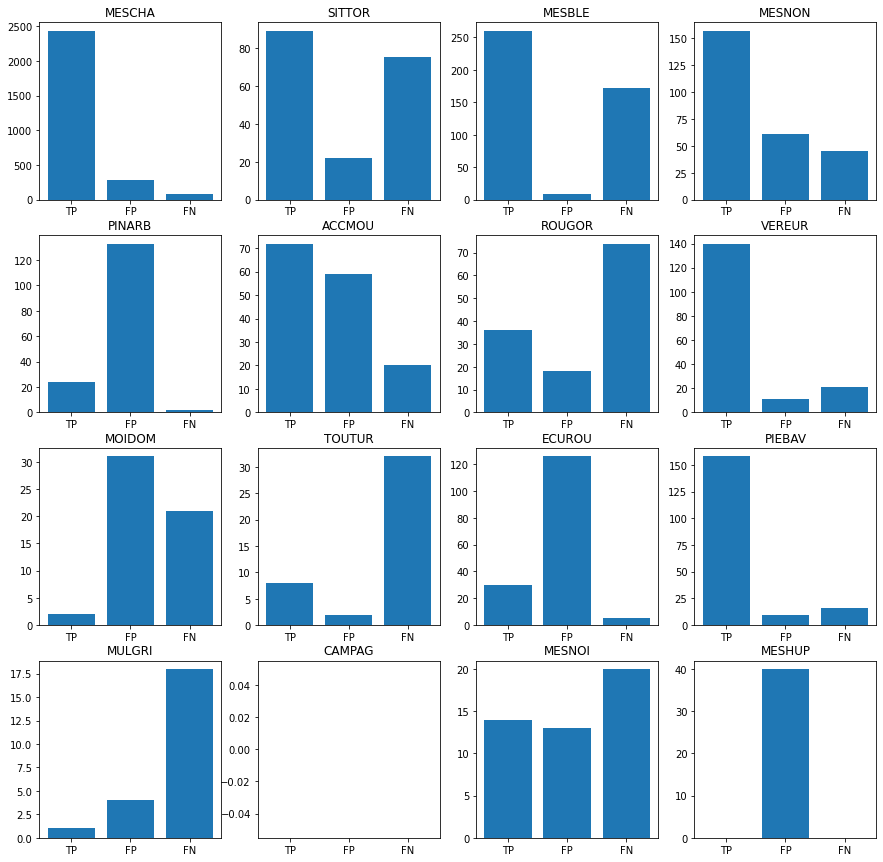

In [55]:
plot_class_metrics(class_metrics)

In [30]:
# fonctions qui sort precision recall et score f1 par classes
def results_metrics_per_classes(class_metrics, list_of_species):
    class_res = []  
    i = 0
    for class_bird in class_metrics:
        TP = class_bird['TP']
        FP = class_bird['FP']
        FN = class_bird['FN']
        if (TP+FP) == 0: 
            P = 0
        else: 
            P = TP/(TP+FP)
        if (TP+FN) == 0: 
            R = 0
        else:
            R = TP/(TP+FN)
        if P == 0 and R == 0:
            F_score = 0
        else:
            F_score = 2*P*R/(P+R)
        class_res.append({'Precision': round(P,3), 'Rappel': round(R,3), 'F-score': round(F_score,3)})
        i += 1
    return class_res

In [31]:
class_res = results_metrics_per_classes(class_metrics, classes)

In [32]:
pickle.dump(class_res, open( "/home/acarlier/code/OrnithoScope/saved_models/class_metrics_efficientDet1.p", "wb" ) )

In [62]:
# fonction qui print les metriques par classes p,r,f1
def print_results_metrics_per_classes(class_res):
    for res in class_res:
        print(f"Precision = {res['Precision']} - Rappel = {res['Rappel']} - F-score = {res['F-score']} ")

In [63]:
print_results_metrics_per_classes(class_res)

Precision = 0.896 - Rappel = 0.968 - F-score = 0.931 
Precision = 0.802 - Rappel = 0.543 - F-score = 0.647 
Precision = 0.967 - Rappel = 0.602 - F-score = 0.742 
Precision = 0.72 - Rappel = 0.777 - F-score = 0.748 
Precision = 0.153 - Rappel = 0.923 - F-score = 0.262 
Precision = 0.55 - Rappel = 0.783 - F-score = 0.646 
Precision = 0.667 - Rappel = 0.327 - F-score = 0.439 
Precision = 0.927 - Rappel = 0.87 - F-score = 0.897 
Precision = 0.061 - Rappel = 0.087 - F-score = 0.071 
Precision = 0.8 - Rappel = 0.2 - F-score = 0.32 
Precision = 0.192 - Rappel = 0.857 - F-score = 0.314 
Precision = 0.946 - Rappel = 0.908 - F-score = 0.927 
Precision = 0.2 - Rappel = 0.053 - F-score = 0.083 
Precision = 0 - Rappel = 0 - F-score = 0 
Precision = 0.519 - Rappel = 0.412 - F-score = 0.459 
Precision = 0.0 - Rappel = 0 - F-score = 0 


In [64]:
# fonction qui plot les p,r,f1 par classes
def plot_class_p_r_f1(class_res,classes):
    i = 0
    l = 1
    fig, axs = plt.subplots(4, 4,figsize=(15,15))

    for class_bird in class_res:
        ax1 = plt.subplot(4, 4, l)
        names = list(class_bird.keys())
        values = list(class_bird.values())
        plt.bar(range(len(class_bird)), values, tick_label=names)
        ax1.set_ylim([0, 1])
        l += 1
        plt.title(classes[i])
        i +=1
    plt.savefig("/home/acarlier/code/OrnithoScope/data/prf1_efficientDet1.jpg")

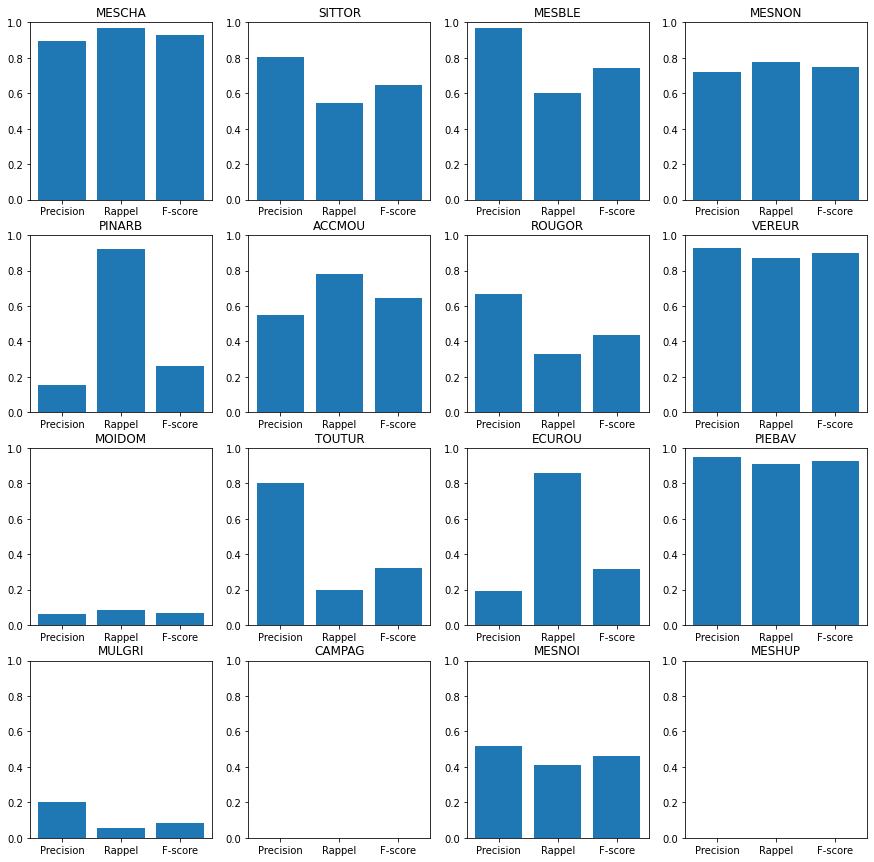

In [65]:
plot_class_p_r_f1(class_res, classes)

In [66]:
class_res

[{'Precision': 0.896, 'Rappel': 0.968, 'F-score': 0.931},
 {'Precision': 0.802, 'Rappel': 0.543, 'F-score': 0.647},
 {'Precision': 0.967, 'Rappel': 0.602, 'F-score': 0.742},
 {'Precision': 0.72, 'Rappel': 0.777, 'F-score': 0.748},
 {'Precision': 0.153, 'Rappel': 0.923, 'F-score': 0.262},
 {'Precision': 0.55, 'Rappel': 0.783, 'F-score': 0.646},
 {'Precision': 0.667, 'Rappel': 0.327, 'F-score': 0.439},
 {'Precision': 0.927, 'Rappel': 0.87, 'F-score': 0.897},
 {'Precision': 0.061, 'Rappel': 0.087, 'F-score': 0.071},
 {'Precision': 0.8, 'Rappel': 0.2, 'F-score': 0.32},
 {'Precision': 0.192, 'Rappel': 0.857, 'F-score': 0.314},
 {'Precision': 0.946, 'Rappel': 0.908, 'F-score': 0.927},
 {'Precision': 0.2, 'Rappel': 0.053, 'F-score': 0.083},
 {'Precision': 0, 'Rappel': 0, 'F-score': 0},
 {'Precision': 0.519, 'Rappel': 0.412, 'F-score': 0.459},
 {'Precision': 0.0, 'Rappel': 0, 'F-score': 0}]

In [71]:
# fonction qui calcule le P,R et F1 score global
def get_p_r_f1_global(class_res):
    l = len(class_res)
    p = 0.0
    r = 0.0
    f = 0.0    
    for class_bird in class_res:
        if class_bird['Precision'] !=0 and class_bird['Rappel'] !=0 and class_bird['F-score'] !=0:
            p += class_bird['Precision']
            r += class_bird['Rappel']
            f += class_bird['F-score']
        else:
            l-=1
    return round(p/l,3),round(r/l,3),round(f/l,3) 

In [72]:
p_global, r_global, f_global = get_p_r_f1_global(class_res)
print(p_global,r_global,f_global)

0.6 0.594 0.535
